In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pandas as pd
import numpy as np
from joblib import dump

We will load our processed data.

In [17]:
X_train = pd.read_csv('../data/processed/X_train_smote.csv')
X_val = pd.read_csv('../data/processed/X_val_smote.csv')
y_train = pd.read_csv('../data/processed/y_train_smote.csv')
y_val = pd.read_csv('../data/processed/y_val_smote.csv')
X_test = pd.read_csv('../data/processed/X_test_smote.csv')

In [18]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()

### 3. Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

Fit the model without hyperparameter tuning.

In [6]:
rf_reg = RandomForestClassifier(random_state=8)
rf_reg.fit(X_train, y_train)

RandomForestClassifier(random_state=8)

In [8]:
from joblib import dump

dump(rf_reg, '../models/rf_reg.joblib')

['../models/rf_reg.joblib']

In [9]:
def random_forest(model):
    y_train_probs = model.predict_proba(X_train)[:, 1]
    y_val_probs = model.predict_proba(X_val)[:, 1]

    train_score = pd.DataFrame({'roc-auc score': roc_auc_score(y_train, y_train_probs)}, index=['Training Set'])
    val_score = pd.DataFrame({'roc-auc score': roc_auc_score(y_val, y_val_probs)}, index=['Validation Set'])

    score = pd.concat([train_score, val_score])
    print(score)
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    
    plt.plot(fpr_train, tpr_train, label='Train ROC-curve')
    plt.plot(fpr_val, tpr_val, label='Validate ROC-curve')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-Curve')
    plt.legend()
    
    plt.show()

                roc-auc score
Training Set         1.000000
Validation Set       0.999966


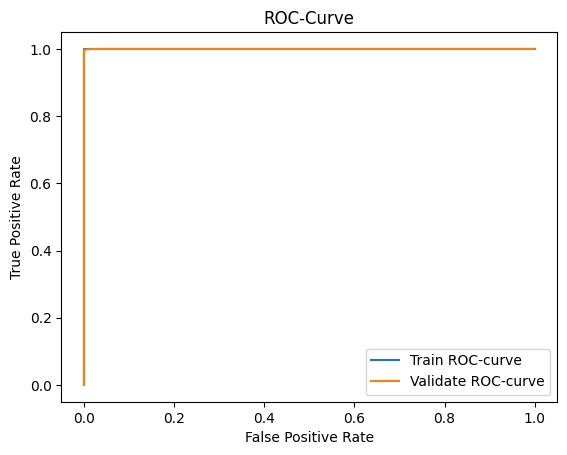

In [10]:
random_forest(rf_reg)

In [11]:
def submission_file(y_test_prob):
    player_id_df = pd.read_csv('../data/processed/player_id.csv')
    
    submission_df = pd.DataFrame({
        'player_id': player_id_df['player_id'],
        'drafted': y_test_prob
    })
    
    submission_df['drafted'] = submission_df['drafted'].round(1)
    return submission_df

In [12]:
y_test_probs = rf_reg.predict_proba(X_test)[:, 1]

In [13]:
submission_1 = submission_file(y_test_probs)

In [14]:
submission_1.to_csv('../data/submission/submission_rf_1.csv', index=False)

#### Hyperparameter Tuning with n_estimators

default = 100

In [19]:
n_estimators = [2, 5, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [20]:
train_score = []
val_score = []
    
for i in n_estimators:
    rf = RandomForestClassifier(random_state=8, n_estimators=i).fit(X_train, y_train)
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_score.append(roc_auc_score(y_train, y_train_probs))
    val_score.append(roc_auc_score(y_val, y_val_probs))       
    
score = pd.DataFrame({'train_score': train_score,
                         'val_score': val_score}, index=n_estimators)
print(score)

     train_score  val_score
2       0.999575   0.997724
5       0.999976   0.999651
10      1.000000   0.999935
20      1.000000   0.999960
50      1.000000   0.999963
100     1.000000   0.999966
150     1.000000   0.999965
200     1.000000   0.999964
250     1.000000   0.999964
300     1.000000   0.999965
350     1.000000   0.999965
400     1.000000   0.999965
450     1.000000   0.999966
500     1.000000   0.999966


#### Hyperparameter Tuning with Max Depth

default = None

In [23]:
max_depth = [2, 5, 10, 20, 50, 100, 150, 200, None]

In [24]:
train_score = []
val_score = []
n_estimators = 100
    
for i in max_depth:
    rf = RandomForestClassifier(random_state=8, n_estimators=n_estimators, max_depth=i).fit(X_train, y_train)
    y_train_probs = rf.predict_proba(X_train)[:, 1]
    y_val_probs = rf.predict_proba(X_val)[:, 1]
        
    train_score.append(roc_auc_score(y_train, y_train_probs))
    val_score.append(roc_auc_score(y_val, y_val_probs))       
    
score = pd.DataFrame({'train_score': train_score,
                         'val_score': val_score}, index=max_depth)
print(score)

       train_score  val_score
2.0       0.981876   0.981905
5.0       0.992425   0.992735
10.0      0.999420   0.999391
20.0      0.999960   0.999927
50.0      1.000000   0.999961
100.0     1.000000   0.999966
150.0     1.000000   0.999966
200.0     1.000000   0.999966
NaN       1.000000   0.999966


#### Hyperparameter Tuning with Min Sample Split

Penalties support by solver were 'l2', and 'none'

default = 2

In [26]:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]

In [27]:
train_score = []
val_score = []
n_estimators = 100
max_depth = None

for i in min_samples_split:
    rg = RandomForestClassifier(random_state=8, n_estimators=n_estimators, max_depth=max_depth, min_samples_split=i).fit(X_train, y_train)
    y_train_probs = rg.predict_proba(X_train)[:, 1]
    y_val_probs = rg.predict_proba(X_val)[:, 1]
        
    train_score.append(roc_auc_score(y_train, y_train_probs))
    val_score.append(roc_auc_score(y_val, y_val_probs))       
    
score = pd.DataFrame({'train_score': train_score,
                         'val_score': val_score}, index=min_samples_split)
print(score)

     train_score  val_score
2       1.000000   0.999966
5       1.000000   0.999957
10      1.000000   0.999958
15      1.000000   0.999956
20      0.999999   0.999943
50      0.999988   0.999918
100     0.999965   0.999849


#### Hyperparameter Tuning with Min Samples Leaf

default = 1

In [29]:
min_samples_leaf = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

In [31]:
train_score = []
val_score = []
n_estimators = 100
max_depth = None
min_samples_split = 2
    
for i in min_samples_leaf:
    rg = RandomForestClassifier(random_state=8, n_estimators=n_estimators,  max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=i).fit(X_train, y_train)
    y_train_probs = rg.predict_proba(X_train)[:, 1]
    y_val_probs = rg.predict_proba(X_val)[:, 1]
        
    train_score.append(roc_auc_score(y_train, y_train_probs))
    val_score.append(roc_auc_score(y_val, y_val_probs))       
    
score = pd.DataFrame({'train_score': train_score,
                         'val_score': val_score}, index=min_samples_leaf)
print(score)

    train_score  val_score
1      1.000000   0.999966
2      1.000000   0.999963
5      0.999995   0.999943
10     0.999980   0.999910
15     0.999951   0.999834
20     0.999902   0.999753
25     0.999834   0.999646
30     0.999745   0.999539
35     0.999608   0.999349
40     0.999511   0.999253
45     0.999374   0.999127
50     0.999182   0.998850


#### Hyperparameter Tuning with Max Features

default = sqrt

In [32]:
max_features = ['sqrt', 'log2', None]

In [33]:
train_score = []
val_score = []
n_estimators = 100
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
    
for i in max_features:
    rg = RandomForestClassifier(random_state=8, n_estimators=n_estimators,  max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=1, max_features=i).fit(X_train, y_train)
    y_train_probs = rg.predict_proba(X_train)[:, 1]
    y_val_probs = rg.predict_proba(X_val)[:, 1]
        
    train_score.append(roc_auc_score(y_train, y_train_probs))
    val_score.append(roc_auc_score(y_val, y_val_probs))       
    
score = pd.DataFrame({'train_score': train_score,
                         'val_score': val_score}, index=max_features)
print(score)


      train_score  val_score
sqrt          1.0   0.999966
log2          1.0   0.999968
None          1.0   0.999900


### Model after hyperparameter tuning

In [182]:
log_reg_tune = LogisticRegression(random_state=8, max_iter=2000, solver='lbfgs', penalty='none', multi_class='auto')
log_reg_tune.fit(X_train, y_train)

/Users/narongvatchingpayakmon/Projects/adv_mla_2023/adv_mla_2023_at1_14229898/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(max_iter=2000, penalty='none', random_state=8)

In [187]:
dump(log_reg_tune, '../models/log_reg_tune.joblib')

['../models/log_reg_tune.joblib']

                roc-auc score
Training Set         0.999868
Validation Set       0.999830


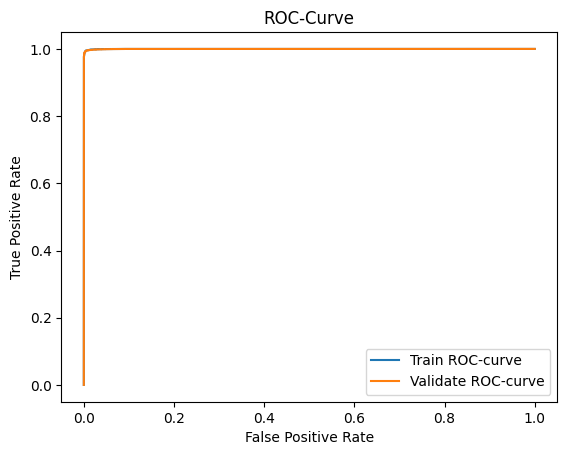

In [188]:
logit(log_reg_tune)

In [190]:
y_test_probs_2 = log_reg_tune.predict_proba(X_test)[:, 1]

In [191]:
submission_2 = submission_file(y_test_probs_2)

In [192]:
submission_2

,player_id,drafted
0,cf302b4d-84f7-4124-a25d-a75eed31978b,0.0
1,f91837cd-4f49-4b70-963d-aeb82c6ce3da,0.0
2,53ec2a29-1e7d-4c6d-86d7-d60d02af8916,0.0
3,32402798-471c-4a54-8cb4-29cd95199014,0.0
4,73b960f9-27b8-4431-9d23-a760e9bbc360,0.0
...,...,...
4965,a25ee55f-02a3-4f8e-8194-a5f427e14e7c,0.0
4966,d0d9f45e-7b01-44b3-8d40-514ec338611d,0.0
4967,f8df22c4-1602-4fab-896d-8820951aae2f,0.0
4968,b791c69a-f769-4163-afda-051a6fd20a9d,0.0


In [193]:
submission_2.to_csv('../data/submission/submission_2.csv', index=False)